Hello world!

# The project: PainterByNumbers  
Classifying two images of paintings, as belonging to the same artist or not.   
Note that, artist in the test set should be different from the artists in the training set.  
Data: https://www.kaggle.com/c/painter-by-numbers.  
Approach: **Convolutional Siamese Network** 



**Students:**   
**Azmi Haider - 308139385**     
**Yael Nagler -** 

# Importing libraries  
**check that you're running on GPU and define helper functions for later:**

In [1]:
import random
import PIL
from PIL import Image
import glob
import os
import torch.nn.functional as F
import torch
import numpy as np
import cv2
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as dset
import torchvision.utils
import matplotlib.pyplot as plt
from datetime import datetime

# check if device is GPU
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('Im running on {}'.format(device))


now = datetime.now()
dt_string = now.strftime("%d_%m_%Y___%H_%M_%S")
print("date and time =", dt_string)

C:\Users\azmih\anaconda3\envs\DL_HW3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Im running on cuda
date and time = 15_03_2023___17_47_16


**Helper functions:**

In [2]:
# helper function for visualization
def tensor_to_image(tensor):
    tensor = (tensor+1)/2 * 255
    tensor = np.array(tensor, dtype=np.uint8)
    tensor= np.transpose(np.squeeze(tensor), [1, 2, 0])
    return PIL.Image.fromarray(tensor,'RGB')


def read_image(im_path):
    try:
        img = Image.open(im_path)
    except:
        print(im_path)
        return
    if img is None:
        print(im_path)
    
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # this annoying dataset has images with 4 channels for some reason
    # need to convert them back to 3 channels
    if len(img.shape) != 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    
    return img


# information about the data, preprocessing

The data has ~1700 painters
I've divided it to 80% training and 20% test.  
Training has 1352 painters  
Test has 349 painters  

Due to data collection issues: some images were corrupted/too large and were removed.   
Due to space issues: the images were centered and cropped to 256x256x3

In [3]:
train_dir = "./Dataset/npy_files/training"
val_dir = "./Dataset/npy_files/validation"
test_dir = "./Dataset/npy_files/test"

save_dir = "./Checkpoints/Triplet_small_" + dt_string

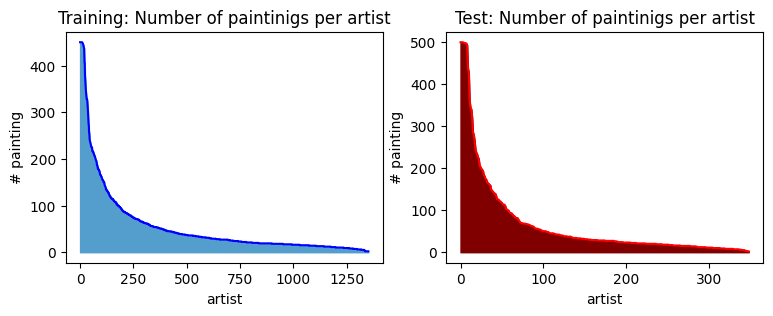

In [4]:
painters_classes = glob.glob(f'{train_dir}/*.npy')
painters_num_paintings = [len(np.load(a)) for a in painters_classes]
painters_num_paintings.sort(reverse=True)

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
x,y = np.arange(len(painters_num_paintings)), painters_num_paintings
plt.plot(x, y, color ='blue')
plt.fill_between(x, y, color='#539ecd')
plt.ylabel('# painting')
plt.xlabel('artist')
plt.title('Training: Number of paintinigs per artist')

painters_classes = glob.glob(f'{test_dir}/*.npy')
painters_num_paintings = [len(np.load(a)) for a in painters_classes]
painters_num_paintings.sort(reverse=True)
plt.subplot(1,2,2)
x,y = np.arange(len(painters_num_paintings)), painters_num_paintings
plt.plot(x, y, color ='red')
plt.fill_between(x, y, color='maroon')
plt.ylabel('# painting')
plt.xlabel('artist')
plt.title('Test: Number of paintinigs per artist')

plt.show()

# Dataset classes:   

**PairDataset (for contrastive loss) and TripletDataset (for triplet loss)**

In [4]:
# A dataset class that returns two images and a label=0 (if images of same artist, label=1 otherwise)
class PairDataset(Dataset):
    def __init__(self,np_files_dir,transform=None):
        self.np_files_dir = np_files_dir     
        self.transform = transform
        self.painters_classes = glob.glob(f'{np_files_dir}/*.npy')
        self.painters_num_paintings = [len(np.load(a)) for a in self.painters_classes]
        self.num_painters = len(self.painters_classes)
        self.num_images = np.sum(self.painters_num_paintings)
                
    def __getitem__(self,index):
        # are we returning two images of the same painter(0) of different (1)?
        different_painter = random.randint(0,1)
        
        if not different_painter: # same painter
            # choose a painter randomly
            chosen_painter_index = random.randrange(self.num_painters)
            # load the npy file of the painter
            painter_npy = np.load(os.path.join(self.np_files_dir,'class'+str(chosen_painter_index)+'.npy'))
            # chose 2 from his paintings
            pnum = len(painter_npy)
            chosen_paintings_indexes = random.sample(range(pnum), 2)
            img0 = painter_npy[chosen_paintings_indexes[0]]
            img1 = painter_npy[chosen_paintings_indexes[1]]
                
        else: # different painter
            # choose two painters randomly
            chosen_two_painters = random.sample(range(self.num_painters), 2)
            # load the npy file of the painters
            painter0_npy = np.load(os.path.join(self.np_files_dir,'class'+str(chosen_two_painters[0])+'.npy'))
            painter1_npy = np.load(os.path.join(self.np_files_dir,'class'+str(chosen_two_painters[1])+'.npy'))
                
            # first painter - choose painting randomly
            pnum = len(painter0_npy)           
            chosen_painting_index = random.randrange(pnum)
            img0 = painter0_npy[chosen_painting_index]
                
            # second painter - choose painting randomly
            pnum = len(painter1_npy)           
            chosen_painting_index = random.randrange(pnum)
            img1 = painter1_npy[chosen_painting_index]
                 

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.Tensor([different_painter])
    
    def __len__(self):
        return self.num_images

In [5]:
# A dataset class that returns anchor, positive, negative images
class TripletDataset(Dataset):
    def __init__(self,np_files_dir,transform=None):
        self.np_files_dir = np_files_dir     
        self.transform = transform
        self.painters_classes = glob.glob(f'{np_files_dir}/*.npy')
        self.painters_num_paintings = [len(np.load(a)) for a in self.painters_classes]
        self.num_painters = len(self.painters_classes)
        self.num_images = np.sum(self.painters_num_paintings)
                
    def __getitem__(self,index):

        two_painters = random.sample(range(self.num_painters), 2)
        # load the npy file of the painters
        painter0 = np.load(os.path.join(self.np_files_dir,'class'+str(two_painters[0])+'.npy'))
        painter1 = np.load(os.path.join(self.np_files_dir,'class'+str(two_painters[1])+'.npy'))

        # first painter - choose painting randomly
        pnum = len(painter0)           
        anchor_indxs = random.sample(range(pnum), 2)
        anchor_image = painter0[anchor_indxs[0]]
        positive_image = painter0[anchor_indxs[1]]
                
        # second painter - choose painting randomly
        pnum = len(painter1)
        painting_indx = random.randrange(pnum)
        negative_image = painter1[painting_indx]
        
        if self.transform is not None:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)
                
        return anchor_image, positive_image , negative_image
    
    def __len__(self):
        return self.num_images

# Define the model class - siamese network

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self, pair_triplet=False):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(), )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(), )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), )

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), )

        self.fc = nn.Sequential(
            nn.Linear(16384, 2048),
            nn.LayerNorm(2048),
            nn.ReLU(), )

        self.pooling1 = nn.MaxPool2d(2, stride=2)
        self.pooling2 = nn.MaxPool2d(2, stride=2)
        self.pooling3 = nn.MaxPool2d(2, stride=2)
        self.pooling4 = nn.MaxPool2d(2, stride=2)
        self.pooling5 = nn.MaxPool2d(2, stride=2)

        self.flat = nn.Flatten()

        self.pair_triplet = pair_triplet

    def forward_once(self, x):  # image of size 3x256x256
        output = self.pooling1(self.conv1(x))  # image = 16x128x128
        output = self.pooling2(self.conv2(output))  # image = 32x64x64
        output = self.pooling3(self.conv3(output))  # image = 64x32x32
        output = self.pooling4(self.conv4(output))  # image = 128x16x16
        output = self.pooling5(self.conv5(output))  # image = 256x8x8
        output = self.flat(output)  # flatten
        output = self.fc(output)  # fully connected
        return output

    def forward(self, input1, input2, input3=None):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = None
        if self.pair_triplet:
            output3 = self.forward_once(input3)
        return output1, output2, output3

# Define the losses:   

The goal of loss is to help organize the feature space.    
  

**Option1: Contrastive loss**

The loss is fed a pair of feature vectors and a label Y=0 if the feature vectors belong to paintings of the same artist, otherwise Y=1.    
The aim is to make feature vectors belonging to paintings of the same artist closer in the feature space, and feature vectors of different artists farther from each other.  
Dw is the euclidean distance between the features of the pair.  
loss :   

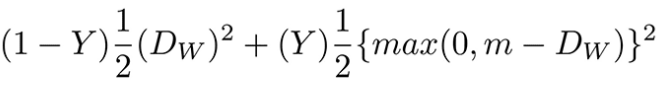

In [7]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def calc_euclidean(self, x1, x2):
        return torch.mean(torch.pow(x1 - x2, 2))
    
    def forward(self, output1, output2, label):
        euclidean_distance = slef.calc_euclidean(output1, output2)
        loss_contrastive = (1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)

        return torch.mean(loss_contrastive)

**Option2: Triplet loss**  
Unlike contrastive loss, Tripet loss operate on three images: anchor, positive, negative.  
Anchor and positive are two feature vectors of images (paintings) of the same class (artist). Negative is from a different class. The goal is to maximize the distance between anchor and negative and minimize the distance between anchor and positive.

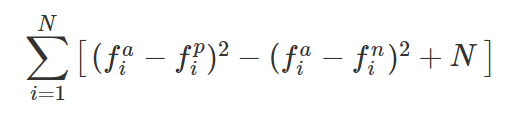

In [8]:
class TripletLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return torch.mean(torch.pow(x1 - x2, 2))
    
    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

# Hyper parameters:

In [9]:
pair_triplet = True # False= pair, contrastive ; True=Triplet 

# loss type
if not pair_triplet:
    loss_func = ContrastiveLoss() 
else:
    loss_func= TripletLoss() #
    
    
base_transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.RandomAffine(degrees=(0, 0), translate=(0.2, 0.2), scale=(1.2, 1.2)),
                              transforms.RandomVerticalFlip(p=0.5),
                              transforms.RandomRotation(degrees=(0, 180)),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
        
#if not os.path.exists(save_dir):
#    os.mkdir(save_dir)



# Divide to train and validation datasets:

In [10]:
train_valid_split = 0.9

if not pair_triplet:
    train_dataset = PairDataset(np_files_dir=train_dir, transform=transform)
    val_dataset = PairDataset(np_files_dir=val_dir, transform=base_transform)
else:
    train_dataset = TripletDataset(np_files_dir=train_dir, transform=transform)
    val_dataset = TripletDataset(np_files_dir=val_dir, transform=base_transform)

#train_size = int(train_valid_split * len(train_dataset))
#val_size = len(train_dataset) - train_size

#train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])



Validation is basically images of artists seen in the training (but the images themselves are not in the training)

In [11]:
print('Number of images in training dataset: {}'.format(len(train_dataset)))
print('Number of images in validation dataset: {}'.format(len(val_dataset)))

Number of images in training dataset: 73183
Number of images in validation dataset: 7083


**Visualize a sample from the training dataloader**

In [12]:
train_batch_size = 4
from torch.utils.data import BatchSampler, RandomSampler
train_dataloader = DataLoader(train_dataset,
                         shuffle=True,
                         num_workers=0,
                         batch_size=train_batch_size)

val_dataloader = DataLoader(val_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=train_batch_size)

In [13]:
print('Number of batches in training: {}'.format(len(train_dataloader)))
print('Number of batches in validation: {}'.format(len(val_dataloader)))

Number of batches in training: 18296
Number of batches in validation: 1771


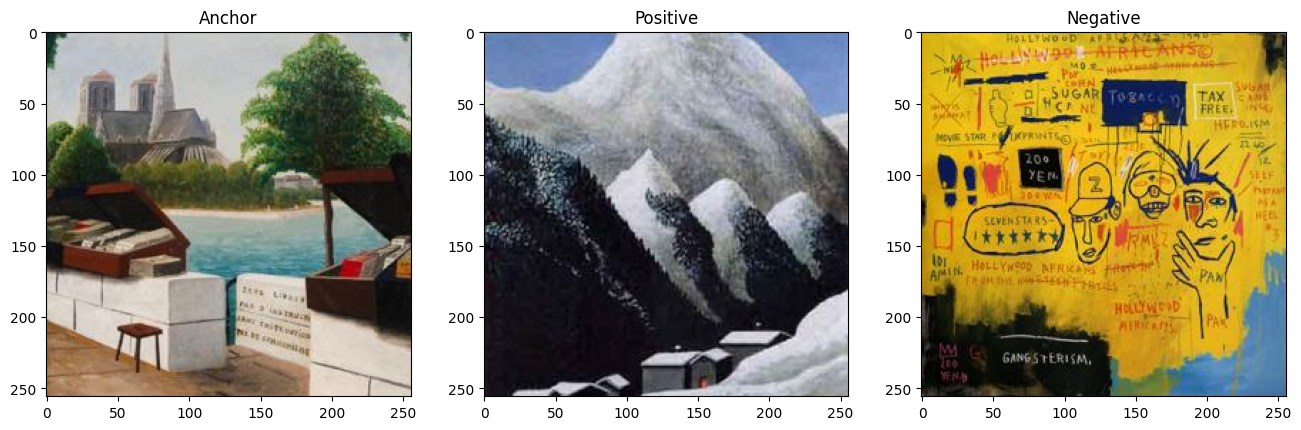

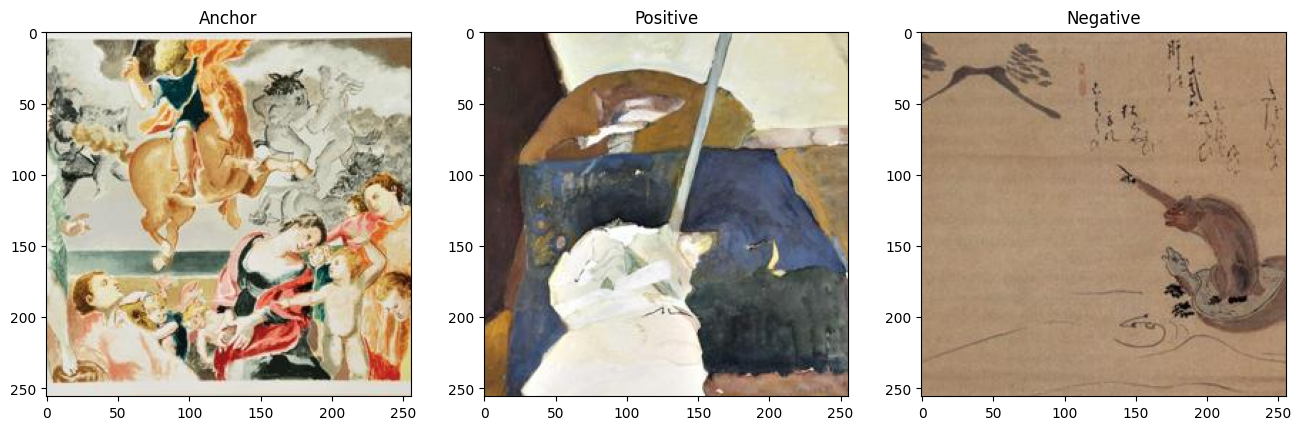

In [32]:
visualize_num_batches = 1 # iterate over # batches
visualize_num_samples = 2 # samples inside a batch to visualize

for i, batch in enumerate(val_dataloader):
    if i>=visualize_num_batches:
        break
    for j in range(visualize_num_samples):
        inputs1,inputs2,inputs3 = batch
        input1, input2, input3 = inputs1[j],inputs2[j],inputs3[j]

        #input1 = torch.squeeze(input1)
        img1 = tensor_to_image(input1)
        img2 = tensor_to_image(input2)

        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        plt.title('Anchor')
        plt.imshow(img1)
        plt.subplot(1,3,2)
        plt.imshow(img2)
    
        if not pair_triplet:
            plt.title('Same artist = '+str(input3.item()==0))
        else:
            plt.title('Positive')
            plt.subplot(1,3,3)
            img3 = tensor_to_image(input3)
            plt.imshow(img3)
            plt.title('Negative')



plt.show()

# batch, channel, W, H


# Train functions

**define an accuracy calculation function and a training function**

In [10]:
def calc_euclidean_distance(output1, output2):
    return torch.mean(torch.pow(output1 - output2, 2)).item()
    
def calc_accuracy(model, dataloader):
    correct = 0
    count = 0
    
    for i, data in enumerate(dataloader,0):
        input1, input2 , input3 = data
        input1, input2 , input3 = input1.to(device), input2.to(device) , input3.to(device)
        output1, output2, output3 = model(input1,input2,input3)
        anchor_anchor_distance = calc_euclidean_distance(output1, output1)
        anchor_positive_distance = calc_euclidean_distance(output1, output2)
        anchor_negative_distance = calc_euclidean_distance(output1, output3)
        if anchor_positive_distance <= anchor_negative_distance:
            correct +=1
        count +=1 
        
    total_correct = correct / count
    return total_correct


def train(model, optimizer, tr_dataloader, v_dataloader, train_number_epochs, scheduler=None):
    train_loss_per_epoch = []
    validation_loss_per_epoch = []
    train_accuracy_per_epoch = []
    validation_accuracy_per_epoch = []
    
    print('Starting training loop: -----------------------------------')
    for epoch in range(train_number_epochs):
    
        # train
        train_loss = []
        for i, data in enumerate(tr_dataloader,0):
            # zero gradients
            optimizer.zero_grad()
            # start
            input1, input2 , input3 = data
            input1, input2 , input3 = input1.to(device), input2.to(device) , input3.to(device)
            # predict
            output1, output2, output3 = net(input1,input2,input3)
            if not pair_triplet: # if the loss is pair - the 3rd input is an label
                output3 = input3
            loss = loss_func(output1,output2,output3)
            #update 
            loss.backward()
            optimizer.step()
            #save loss for later
            train_loss.append(loss.detach())
        
        # validation
        validation_loss = []
        for i, data in enumerate(v_dataloader,0):
            input1, input2 , input3 = data
            input1, input2 , input3 = input1.to(device), input2.to(device) , input3.to(device)
            output1, output2, output3 = net(input1,input2,input3)
            loss = loss_func(output1,output2,output3)
            validation_loss.append(loss.detach())
        
        
        # scheduler
        if scheduler is not None:
            scheduler.step()
            
            
        # aggregate results
        train_loss_per_epoch.append(torch.mean(torch.tensor(train_loss)))
        validation_loss_per_epoch.append(torch.mean(torch.tensor(validation_loss)))
        
        #train_accuracy_per_epoch.append(calc_accuracy(net, tr_dataloader))
        #validation_accuracy_per_epoch.append(calc_accuracy(net, v_dataloader))
    
    
        print("Epoch number {} - Current train loss {} ==================".format(epoch, torch.mean(torch.tensor(train_loss))))
        #print("val similarity distance = {}".format(similarity))
        #print("val dissimilarity distance {} = ".format(dissimilarity))
        if (epoch+1) % 5 == 0:
            # save checkpoint
            torch.save(net.state_dict(), os.path.join(save_dir,'checkpoint_epoch'+str(epoch)))
            
    np.save(os.path.join(save_dir, 'train_loss_per_epoch.npy'), train_loss_per_epoch)
    np.save(os.path.join(save_dir, 'validation_loss_per_epoch.npy'), validation_loss_per_epoch)
    np.save(os.path.join(save_dir, 'train_accuracy_per_epoch.npy'), train_accuracy_per_epoch)
    np.save(os.path.join(save_dir, 'validation_accuracy_per_epoch.npy'), validation_accuracy_per_epoch)

# Train -----------> :

**Hyper parameters**

In [55]:
# train_number_epochs = 5
# learning_rate = 0.0001

# net = SiameseNetwork(pair_triplet=pair_triplet).to(device)
# optimizer = optim.Adam(net.parameters(),lr = learning_rate)
# scheduler = MultiStepLR(optimizer, milestones=[12,16], gamma=0.1)


In [11]:
# clear gpu cache
#torch.cuda.empty_cache()

**train**

In [57]:
# train function
#train(net, optimizer, train_dataloader, val_dataloader, train_number_epochs, scheduler)

# important note:
**The model was trained on a stronger machine with the same parameters**    
**The losses and accuracies (per epoch) were saved and will be uploaded.**  


# Load model

In [11]:
net = SiameseNetwork(pair_triplet=pair_triplet).to(device)
#net = nn.DataParallel(net)
load_dir = './Checkpoints/Triplet_batch4_2'
net.load_state_dict(torch.load(os.path.join(load_dir,'checkpoint_epoch59')))
print('Model loaded successfully')

trained_epochs = 60

Model loaded successfully


**Loss:**

In [11]:
# load losses
train_loss_per_epoch = np.load(os.path.join(load_dir,'train_loss_per_epoch.npy'))
validation_loss_per_epoch = np.load(os.path.join(load_dir,'validation_loss_per_epoch.npy'))

Text(0.5, 1.0, 'Loss graph: ')

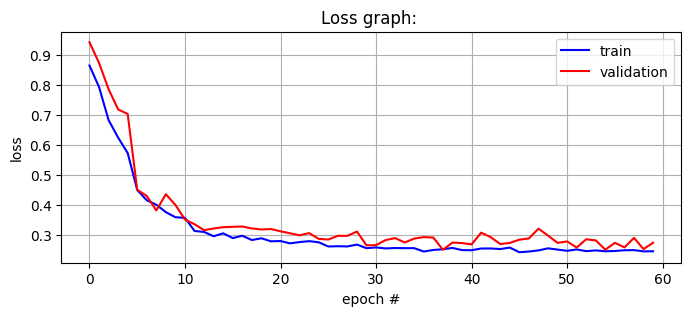

In [12]:
# plot loss
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(trained_epochs), train_loss_per_epoch, 'b', label='train')
plt.plot(np.arange(trained_epochs), validation_loss_per_epoch, 'r', label='validation')
plt.grid(True)
plt.xlabel('epoch #')
plt.ylabel('loss')
plt.legend()
plt.title('Loss graph: ')


**Accuracy:**

In [13]:
# load accuracy
train_accuracy_per_epoch = np.load(os.path.join(load_dir,'train_accuracy_per_epoch.npy'))
validation_accuracy_per_epoch = np.load(os.path.join(load_dir,'validation_accuracy_per_epoch.npy'))

Text(0.5, 1.0, 'Accuracy graph: ')

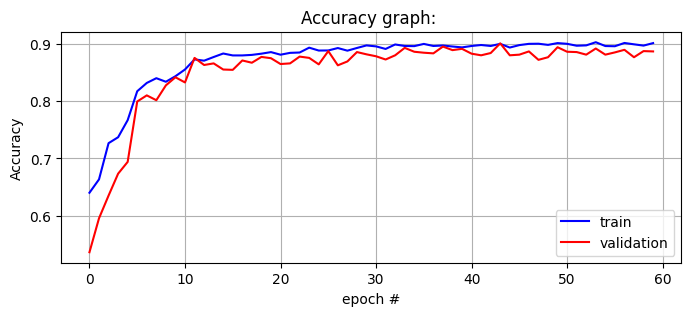

In [14]:
# plot accuracy
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(trained_epochs), train_accuracy_per_epoch, 'b', label='train')
plt.plot(np.arange(trained_epochs), validation_accuracy_per_epoch, 'r', label='validation')
plt.grid(True)
plt.xlabel('epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy graph: ')

# Test: 

**artists in the test set are not seen in the training, not even one painting of theirs**

In [12]:
test_dataset = TripletDataset(np_files_dir=test_dir,transform=base_transform)
test_dataloader = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=4)

In [26]:
print('Number of images in the test set: {}'.format(len(test_dataset)))

Number of images in the test set: 22237


In [27]:
test_accuracy = calc_accuracy(net, test_dataloader)
print('Test accuracy - {}'.format(test_accuracy))

Test accuracy - 0.8928057553956834


Running a visual test --------------------------


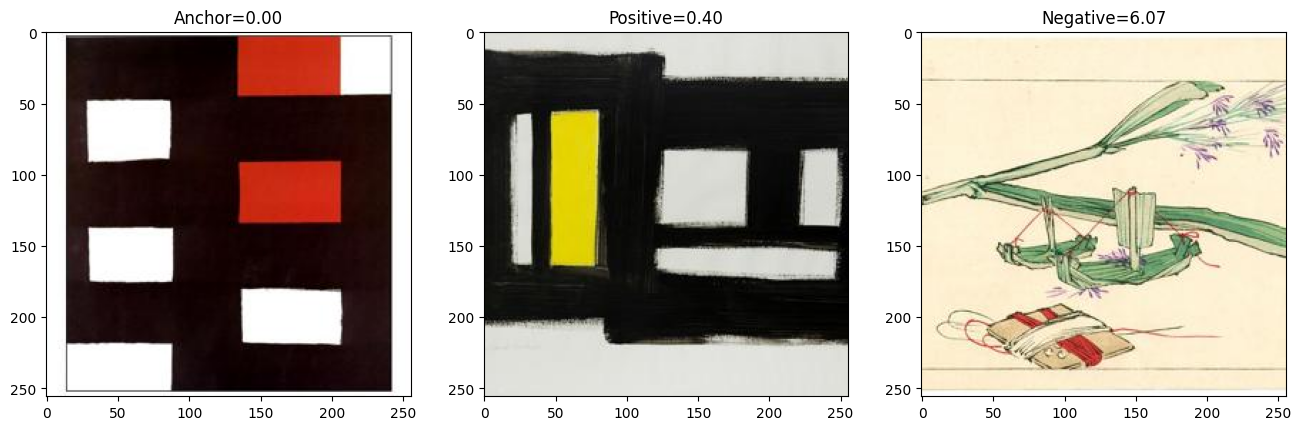

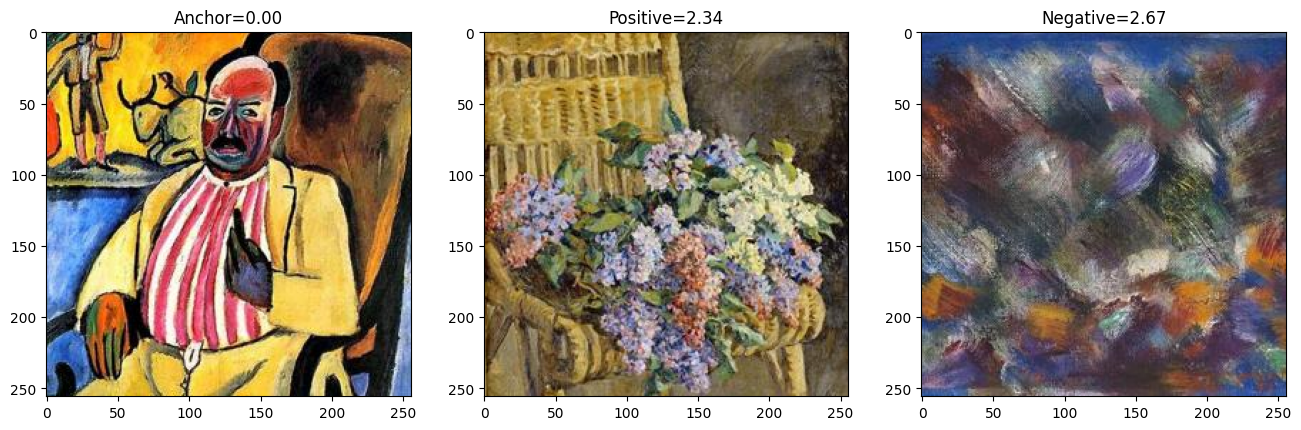

In [28]:
print('Running a visual test --------------------------')

visualize_num_batches = 1 # iterate over # batches
visualize_num_samples = 2 # samples inside a batch to visualize

for i, batch in enumerate(test_dataloader):
    if i>visualize_num_batches:
        break
    inputs1,inputs2,inputs3 = batch
    
    output1, output2, output3 = net(inputs1.to(device), inputs2.to(device), inputs3.to(device))

    anchor_anchor_distance = calc_euclidean_distance(output1[i], output1[i])
    anchor_positive_distance = calc_euclidean_distance(output1[i], output2[i])
    negative_distance = calc_euclidean_distance(output1[i], output3[i])
    
    #print(anchor_positive_distance)

    
    img1 = tensor_to_image(inputs1[i])
    img2 = tensor_to_image(inputs2[i])
    img3 = tensor_to_image(inputs3[i])

    plt.figure(figsize = (16,8))

    plt.subplot(1,3,1)
    plt.imshow(img1)
    plt.title('Anchor={:.2f}'.format(anchor_anchor_distance))
    plt.subplot(1,3,2)
    plt.imshow(img2)
    plt.title('Positive={:.2f}'.format(anchor_positive_distance))
    plt.subplot(1,3,3)

    plt.imshow(img3)
    plt.title('Negative={:.2f}'.format(negative_distance))


plt.show()

In [13]:
print('ROC --------------------------')

positive = []
negative = []

for i, batch in enumerate(test_dataloader):

    inputs1,inputs2,inputs3 = batch
    
    output1, output2, output3 = net(inputs1.to(device), inputs2.to(device), inputs3.to(device))
    
    for j in range(len(output1)):
        #anchor_anchor_distance = calc_euclidean_distance(output1[j], output1[j])
        anchor_positive_distance = calc_euclidean_distance(output1[j], output2[j])
        negative_distance = calc_euclidean_distance(output1[j], output3[j])
    
        positive.append(anchor_positive_distance)
        negative.append(negative_distance)
    

ROC --------------------------


Text(0.5, 1.0, 'ROC')

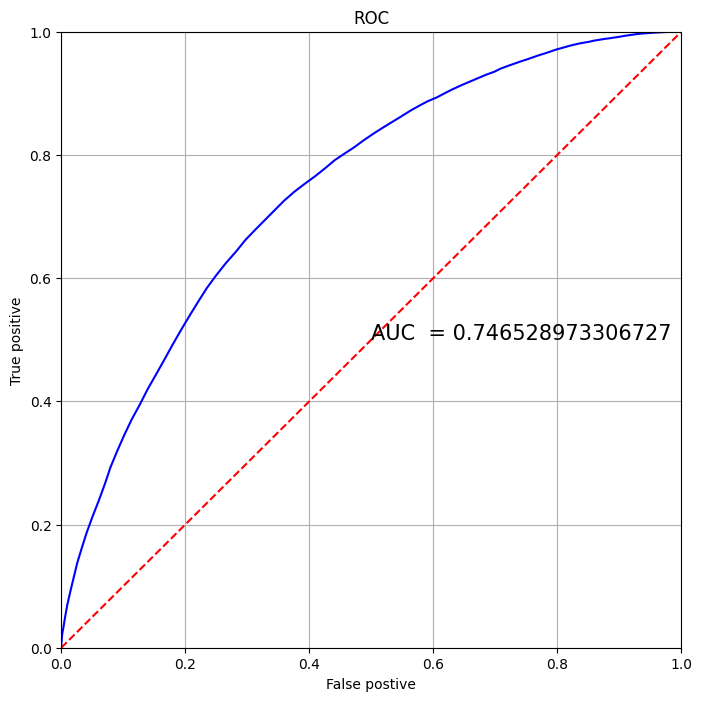

In [26]:
from sklearn.metrics import auc

thresholds = np.arange(0,20,0.1)
total = len(positive)
positive_arr = np.array(positive)
negative_arr = np.array(negative)

true_positive, true_negative, false_positive, false_negative = [], [], [], []

for i,t in enumerate(thresholds):
    true_positive.append(np.sum(positive_arr<=t)/ total) # 
    true_negative.append(np.sum(negative_arr>t)/ total)
    false_positive.append(np.sum(negative_arr<t)/ total)
    false_negative.append(np.sum(positive_arr>t)/ total)
    
fig = plt.figure(figsize=(8,8))
plt.plot(false_positive, true_positive, 'b')
plt.plot(np.arange(0,20,0.1), np.arange(0,20,0.1), '--r')
plt.text(0.5,0.5,f'AUC  = {auc(false_positive, true_positive)}', fontsize=15)
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False postive')
plt.ylabel('True positive')
plt.title('ROC')

In [27]:
from sklearn.metrics import auc
print(f'AUC  = {auc(false_positive, true_positive)}')

AUC  = 0.746528973306727
